In [3]:
import numpy
numpy.seterr(divide='warn')
import pandas
from tkinter import Tk
from tkinter.filedialog import askdirectory
import seaborn
import matplotlib.pyplot as plt
import math
import xlsxwriter

In [4]:
experimentPath = "/Users/alex/Library/Mobile Documents/com~apple~CloudDocs/School/Masters/BME_207/Term Project/20221202_Initial_Full_Data_Run"#askdirectory(title='Select Folder Containing the experiment data')
print(experimentPath)
IMUData = pandas.read_csv("{}/20221202_IMUAngleData.csv".format(experimentPath))
MCData = pandas.read_csv("{}/20221202_MotionCaptureAngleData.csv".format(experimentPath))
LogData = pandas.read_csv("{}/20221202_FullDataArmLog.txt".format(experimentPath), delimiter=';')
videoFramerate = 59.94
MCData['Time'] = MCData['Frame'].values/videoFramerate
MCData['Normed Angle'] = MCData['Angle'].values[0] - MCData['Angle'].values
LogData['Logs'] = LogData['Speeds before shuffling']
logSpeedsStart = int(numpy.where(LogData['Logs'] == "Speeds after shuffling")[0]) + 1
logSpeedsEnd = int(numpy.where(LogData['Logs'] == "Press both limit switches to begin calibration")[0])
logSpeeds = LogData['Logs'].values[logSpeedsStart : logSpeedsEnd]

/Users/alex/Library/Mobile Documents/com~apple~CloudDocs/School/Masters/BME_207/Term Project/20221202_Initial_Full_Data_Run


<AxesSubplot: >

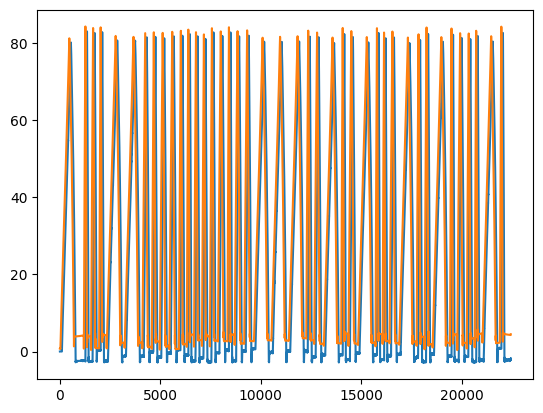

In [5]:


MCtimeVec = numpy.arange(0, max(MCData['Time']), IMUData['Time'].values[1])
IMUtimeVec = numpy.arange(0, max(IMUData['Time']), IMUData['Time'].values[1])
trimLength = min([len(MCtimeVec), len(IMUtimeVec),])
MCAngle = numpy.interp(MCtimeVec, MCData['Time'].values, MCData['Normed Angle'].values)[len(MCtimeVec)-trimLength:]
MCtimeVec = MCtimeVec[len(MCtimeVec)-trimLength:]
IMUAngle = numpy.interp(IMUtimeVec, IMUData['Time'].values, IMUData['IMU Arm Angle'].values)[len(IMUtimeVec)-trimLength:]
IMUtimeVec = IMUtimeVec[len(IMUtimeVec)-trimLength:]
seaborn.lineplot(MCAngle)
seaborn.lineplot(IMUAngle)

78


<AxesSubplot: >

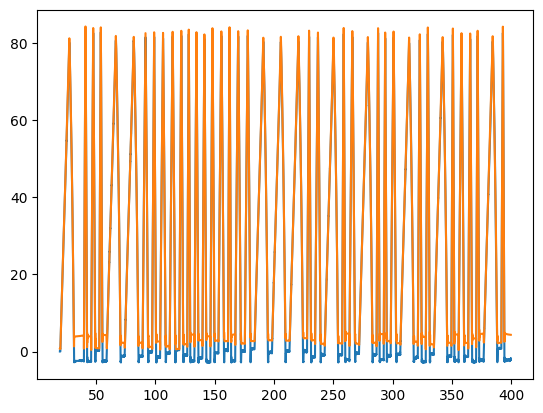

In [6]:
corr = numpy.correlate(MCAngle, IMUAngle, mode='full')
lag = corr.argmax() - (len(MCAngle) - 1)
print(lag)
if lag > 0:
    MCAngle = MCAngle[lag:]
    MCtimeVec = MCtimeVec[lag:]
    IMUAngle = IMUAngle[:-lag]
    IMUtimeVec = IMUtimeVec[:-lag]
    sharedTimeVec = IMUtimeVec
elif lag < 0:
    lag = numpy.abs(lag)
    MCAngle = MCAngle[:-lag]
    MCtimeVec = MCtimeVec[:-lag]
    IMUAngle = IMUAngle[lag:]
    IMUtimeVec = IMUtimeVec[lag:]
    sharedTimeVec = MCtimeVec

# seaborn.lineplot(corr)
seaborn.lineplot(y=MCAngle, x = sharedTimeVec)
seaborn.lineplot(y=IMUAngle, x = sharedTimeVec)
    

- Statistical Analysis
- ANOVA of:
    - Speed groups + steady state - difference
- Regression:
    - Difference against mean
    - Difference against angular velocity
- Power Analysis:
    - "the root-meansquare errors achieved by the best IOE algorithms are in the range of 1° to 3° for slow and smooth motions and as much as 5° to 15° for fast and challenging motions [12, 19]. Further improving this accuracy seems highly desirable in view of numerous applications." Laidig
    - Comparison of RMS error accross whole movement.
    - alpha 95 beta 80, detect a different of 3 degrees
    - RMS error for each move
    - Standard deviation of each move RMS

- Video Report
- Video of the experiment
- Rubric:
    - Overview
    - Procedure
    - Results
    - Discussion

    OR?

    - Executive Summary
    - Significance
    - Results/Discussion
    - Conclusions

https://cloudfront.jove.com/files/media/AuthorProducedCriteria.pdf

In [7]:
MCVel = numpy.diff(MCAngle)/numpy.mean(numpy.diff(sharedTimeVec))
IMUVel = numpy.diff(IMUAngle)/numpy.mean(numpy.diff(sharedTimeVec))

<AxesSubplot: >

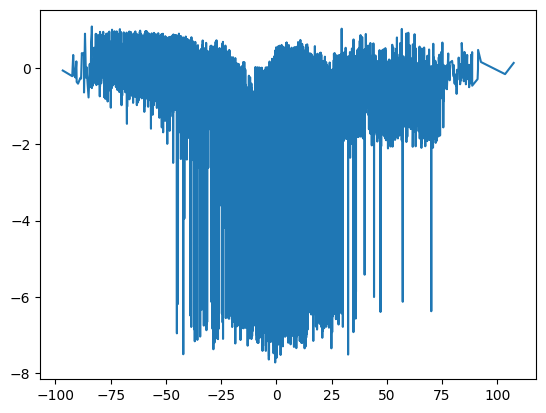

In [8]:
dataSum = IMUAngle + MCAngle
mean = dataSum/2
difference = MCAngle - IMUAngle
# seaborn.lineplot(y=difference, x=mean)
seaborn.lineplot(y=difference[:-1], x=(MCVel + IMUVel)/2)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encount

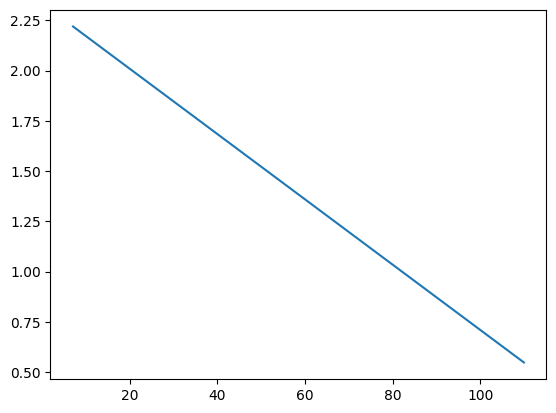

In [9]:
bins = [-5, 7, 110]
indices = numpy.digitize(mean, bins)
binnedDifference = []
binnedMeanDiff = []
binnedStdDiff = []
numInBin = []
for i in range(len(bins)):
    locs = numpy.where(indices == i)
    diff = difference[locs]
    binnedDifference.append(diff)
    binnedMeanDiff.append(numpy.mean(diff))
    binnedStdDiff.append(numpy.std(diff))
    numInBin.append(len(diff))

seaborn.lineplot(y=binnedStdDiff, x=bins)
maxSTD = max(binnedStdDiff)

<AxesSubplot: >

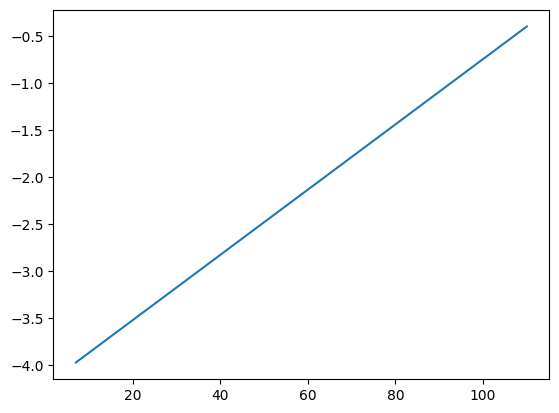

In [10]:
seaborn.lineplot(y=binnedMeanDiff, x=bins)

<AxesSubplot: >

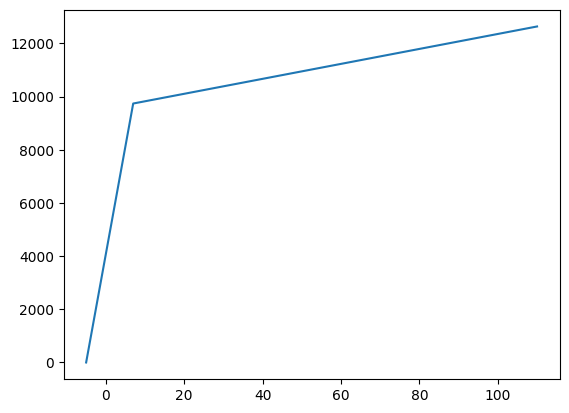

In [11]:
seaborn.lineplot(y=numInBin, x=bins)

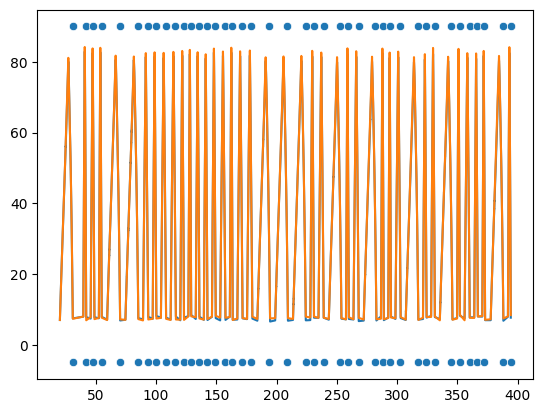

In [12]:
indexThreshold = 1
seaborn.lineplot(y=MCAngle[numpy.where(indices>indexThreshold)], x=sharedTimeVec[numpy.where(indices>indexThreshold)])
seaborn.lineplot(y=IMUAngle[numpy.where(indices>indexThreshold)], x=sharedTimeVec[numpy.where(indices>indexThreshold)])
timeDuringMove = sharedTimeVec[numpy.where(indices>indexThreshold)]
timeDiff = numpy.diff(timeDuringMove)
timeSkips = numpy.where(timeDiff > 1)[0]
movementEnd = numpy.searchsorted(sharedTimeVec, timeDuringMove[timeSkips])
movementEnd = numpy.append(movementEnd, numpy.where(sharedTimeVec == max(timeDuringMove)))
movementStart = numpy.searchsorted(sharedTimeVec, timeDuringMove[timeSkips+1])

vLineX = numpy.empty((movementEnd.size + movementEnd.size,), dtype=movementEnd.dtype)
vLineY = numpy.empty((movementEnd.size + movementEnd.size,), dtype=movementEnd.dtype)
vLineX[0::2] = sharedTimeVec[movementEnd]
vLineX[1::2] = sharedTimeVec[movementEnd]
vLineY[0::2] = -5* numpy.ones(len(movementEnd))
vLineY[1::2] = 90* numpy.ones(len(movementEnd))
seaborn.scatterplot(y=vLineY, x=vLineX)
cycles = {}
slowMoves = numpy.array(numpy.empty((2, 1)))
medSlowMoves = numpy.array(numpy.empty((2, 1)))
medFastMoves = numpy.array(numpy.empty((2, 1)))
fastMoves = numpy.array(numpy.empty((2, 1)))
cyclesSummary = pandas.DataFrame({"Move": [],\
                                 "Mean Difference": [],\
                                 "St Dev Difference": [],\
                                 "RMS Difference": [],\
                                 "Speed": []})
for i in range(len(logSpeeds)):
    if i == 0:
        cycle = pandas.DataFrame()
        cycle['Calibration MC'] = MCAngle[0:int(movementEnd[i])]
        cycle["Calibration IMU"] = IMUAngle[0:int(movementEnd[i])]
        cycles['Calibration'] = cycle
    
    mcMove = MCAngle[movementStart[i]:movementEnd[i+1]]
    imuMove = IMUAngle[movementStart[i]:movementEnd[i+1]]
    timeMove = sharedTimeVec[movementStart[i]:movementEnd[i+1]]
    differenceMove = mcMove - imuMove
    meanMove = (mcMove + imuMove)/2
    cycle = pandas.DataFrame({"MC Move (°)".format(i+1): mcMove,\
                              "IMU Move (°)".format(i+1): imuMove,\
                              "Difference (MC - IMU°)" : differenceMove,\
                              "Mean (°)" : meanMove,\
                              "Time (s)": timeMove})
    # Prepare summary statistics
    meanDifferenceMove = numpy.average(differenceMove)
    stdDifferenceMove = numpy.std(differenceMove)
    rmsDifferenceMove = numpy.sqrt(numpy.mean(differenceMove**2))

    # Extract dwell period
    dwellName = "Dwell {}".format(i+1)
    mcDwell = MCAngle[movementEnd[i]:movementStart[i]]
    imuDwell = IMUAngle[movementEnd[i]:movementStart[i]]
    timeDwell = sharedTimeVec[movementEnd[i]:movementStart[i]]
    differenceDwell = mcDwell - imuDwell
    meanDwell = (mcDwell + imuDwell)/2
    dwell = pandas.DataFrame({"MC Move (°)".format(i+1): mcDwell,\
                              "IMU Move (°)".format(i+1): imuDwell,\
                              "Difference (MC - IMU°)" : differenceDwell,\
                              "Mean (°)" : meanDwell,\
                              "Time (s)": timeDwell})
    # Prepare summary statistics
    meanDifferenceDwell = numpy.average(differenceDwell)
    stdDifferenceDwell = numpy.std(differenceDwell)
    rmsDifferenceDwell = numpy.sqrt(numpy.mean(differenceDwell**2))

    dwellSummary = pandas.DataFrame({"Move": [dwellName],\
                                 "Mean Difference": [meanDifferenceDwell],\
                                 "St Dev Difference": [stdDifferenceDwell],\
                                 "RMS Difference": [rmsDifferenceDwell],\
                                 "Speed": [4]})

    if '0' in logSpeeds[i]:
        moveName = "Slow Move {}".format(i+1)
        slowMoves = numpy.array([numpy.concatenate((slowMoves[0], mcMove)), numpy.concatenate((slowMoves[1], imuMove))])
        moveSummary = pandas.DataFrame({"Move": [moveName],\
                                 "Mean Difference": [meanDifferenceMove],\
                                 "St Dev Difference": [stdDifferenceMove],\
                                 "RMS Difference": [rmsDifferenceMove],\
                                 "Speed": [0]})
    if '1' in logSpeeds[i]:
        moveName = "Medium Slow Move {}".format(i+1)
        medSlowMoves = numpy.array([numpy.concatenate((medSlowMoves[0], mcMove)), numpy.concatenate((medSlowMoves[1], imuMove))])
        moveSummary = pandas.DataFrame({"Move": [moveName],\
                                 "Mean Difference": [meanDifferenceMove],\
                                 "St Dev Difference": [stdDifferenceMove],\
                                 "RMS Difference": [rmsDifferenceMove],\
                                 "Speed": [1]})
    if '2' in logSpeeds[i]:
        moveName = "Medium Fast Move {}".format(i+1)
        medFastMoves = numpy.array([numpy.concatenate((medFastMoves[0], mcMove)), numpy.concatenate((medFastMoves[1], imuMove))])
        moveSummary = pandas.DataFrame({"Move": [moveName],\
                                 "Mean Difference": [meanDifferenceMove],\
                                 "St Dev Difference": [stdDifferenceMove],\
                                 "RMS Difference": [rmsDifferenceMove],\
                                 "Speed": [2]})
    if '3' in logSpeeds[i]:
        moveName = "Fast Move {}".format(i+1)
        fastMoves = numpy.array([numpy.concatenate((fastMoves[0], mcMove)), numpy.concatenate((fastMoves[1], imuMove))])
        moveSummary = pandas.DataFrame({"Move": [moveName],\
                                 "Mean Difference": [meanDifferenceMove],\
                                 "St Dev Difference": [stdDifferenceMove],\
                                 "RMS Difference": [rmsDifferenceMove],\
                                 "Speed": [3]})
    
    cyclesSummary = pandas.concat([cyclesSummary, moveSummary], ignore_index=True)
    cyclesSummary = pandas.concat([cyclesSummary, dwellSummary], ignore_index=True)
    cycles[moveName] = cycle
    cycles[dwellName] = dwell



In [13]:
writer = pandas.ExcelWriter('ProcessedArmData.xlsx', engine='xlsxwriter')
for item in cycles:
    # print(cycles[item])
    cycles[item].to_excel(writer, sheet_name = item)
writer.save()

writer = pandas.ExcelWriter('SummarizedArmData.xlsx', engine='xlsxwriter')
cyclesSummary.to_excel(writer, sheet_name = "Data Summary")
writer.save()

rawData = pandas.DataFrame({"Time": sharedTimeVec[:-1],\
                            "Difference": difference[:-1],\
                            "Mean": mean[:-1],\
                            "Mean Angular Velocity": (MCVel + IMUVel)/2,\
                            "MC Data": MCAngle[:-1],\
                            "IMU Data": IMUAngle[:-1]})

writer = pandas.ExcelWriter('RawArmData.xlsx', engine='xlsxwriter')
rawData.to_excel(writer, sheet_name = "Raw Data")
writer.save()

<AxesSubplot: >

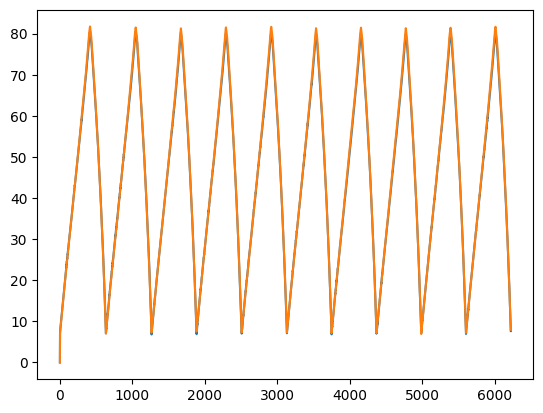

In [14]:
seaborn.lineplot(slowMoves[0])
seaborn.lineplot(slowMoves[1])

<AxesSubplot: >

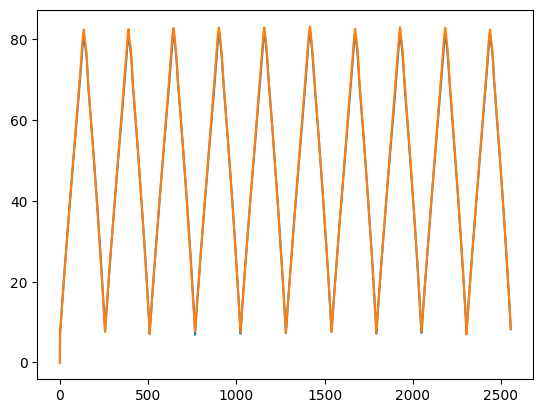

In [15]:
seaborn.lineplot(medSlowMoves[0])
seaborn.lineplot(medSlowMoves[1])

<AxesSubplot: >

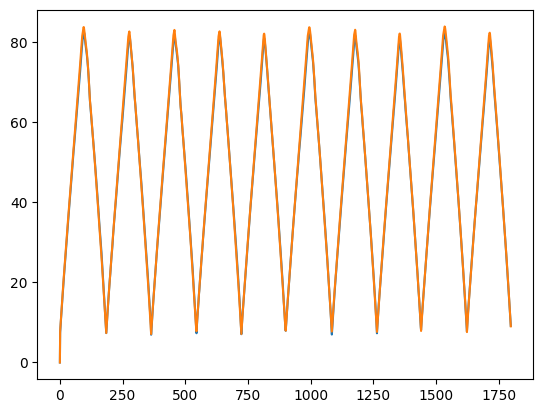

In [16]:
seaborn.lineplot(medFastMoves[0])
seaborn.lineplot(medFastMoves[1])

<AxesSubplot: >

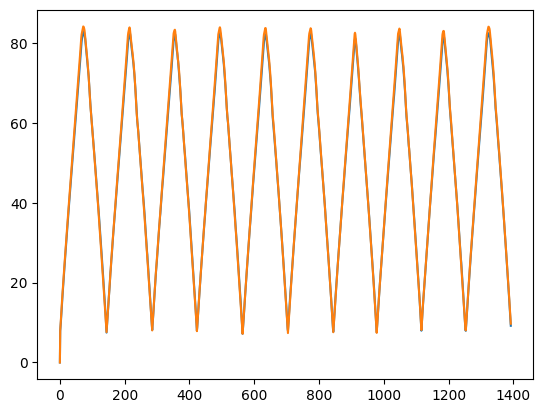

In [17]:
seaborn.lineplot(fastMoves[0])
seaborn.lineplot(fastMoves[1])